# Working with local files

At heart, `contextily` is a package to work with data from the web. Its main functionality allows you to access tilesets exposed through the popular XYZ format and include them in your workflow through `matplotlib`. However, a little hidden gem in the pacakge is also how it is useful to work with local files. For all this functionality, `contextily` relies on `rasterio` so, in the name of showing how a streamlined workflow could look like, we will switch back and forth between the two in this notebook. For good measure, we will also use `geopandas` as it'll show how they are all a family that works great together!

In [26]:
%matplotlib inline

import contextily as ctx
import geopandas
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt

## Saving tiles locally

The first usecase is when you want to store locally a basemap you have accessed with `contextily`. For example, let's say  you are visualising a point dataset. In this case, let's pull the [CLIWOC `routes`](https://figshare.com/articles/CLIWOC_Slim_and_Routes/11941224) dataset, which records ship routes from the XVIIth to XIXth Centuries:

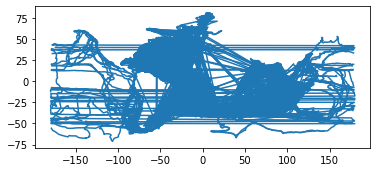

In [7]:
cliwoc = geopandas.read_file("https://ndownloader.figshare.com/files/21940242")
cliwoc.plot()

A quick plot reveals some structure, but it is a bit hard to see much. Let's style the routes a bit and add a basemap:

/opt/conda/lib/python3.7/site-packages/contextily/tile.py:580: RuntimeWarning: divide by zero encountered in log2
  zoom_lon = np.ceil(np.log2(360 * 2.0 / lon_length))


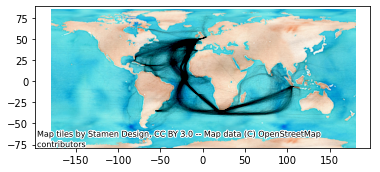

In [14]:
ax = cliwoc.plot(linewidth=0.01, alpha=0.5, color="k")
ctx.add_basemap(ax, 
                crs=cliwoc.crs.to_string(),
                source=ctx.providers.Stamen.Watercolor
               )

Now this is better! But imagine that you wanted to take this map to a Desktop GIS (like [QGIS](https://qgis.org/en/site/)) and maybe do some more work; or that you simply wanted to retain a copy of the basemap in case you need to work offline. In those cases, `contextily` lets you download a basemap off the internet directly into a common GeoTIF file.

The quickest way to visualise a `GeoTIF` file is with `rasterio`:

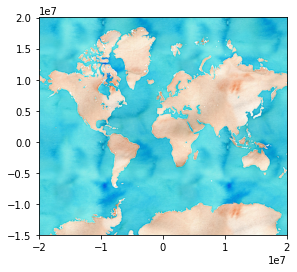

In [27]:
with rasterio.open("world_watercolor.tif") as r:
    rioshow(r)

Note how the data is the same but it's expressed in a different projection. This is because a basemap is always stored in its original CRS, Web Mercator. See below how you can modify that on-the-fly with `contextily`.

### Raster from bounds

The workhorse here is `bounds2raster`, which expects a bounding box and downloads a basemap for that area into a local `.tif` file. Let's see for the example above. First, we need to extract the bounds of our dataset, which will set the extent of the download:

In [17]:
west, south, east, north = bbox = cliwoc.total_bounds
bbox

array([-179.98,  -71.17,  179.98,   80.8 ])

Then we can download the tile:

In [20]:
img, ext = ctx.bounds2raster(west, 
                             south, 
                             east, 
                             north, 
                             "world_watercolor.tif", 
                             source=ctx.providers.Stamen.Watercolor,
                             ll=True
                            )

Note that, since our bounding box was expressed in lon/lat, we pass `ll=True` so the function knows about it. 

You should now see a file written locally named `world_watercolor.tif`. This is saved in a standard format that any GIS should be able to read.

### Raster from name

The other option `contextily` includes to save rasters is through its Place API, which allows you to query locations through their names (thanks to [`geopy`](https://geopy.readthedocs.io/en/stable/)). For example, we can retrieve a basemap of Sao Paulo:

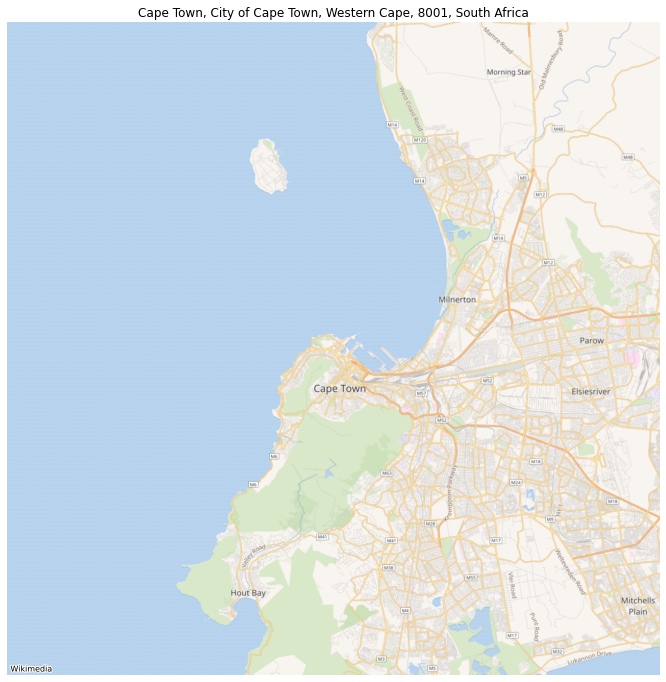

In [54]:
sao_paulo = ctx.Place("Cape Town", source=ctx.providers.Wikimedia)
sao_paulo.plot()

Now, if we want to store the basemap in a file as we download it, you can pass a path to the `path` argument:

In [55]:
sao_paulo = ctx.Place("Cape Town", source=ctx.providers.Wikimedia, path="cape_town.tif")

And this should create a new file on your local directory.

## Reading local rasters

### Reading with `rasterio`

`rasterio` allows us to move quickly from file to plot if we want to inspect what's saved:

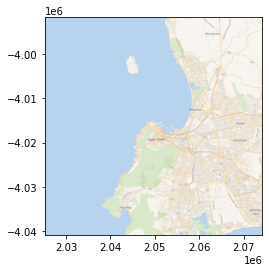

In [56]:
with rasterio.open("cape_town.tif") as r:
    rioshow(r)

### Reading with `add_basemap`

If we are combining a locally stored raster with other data (e.g. vector), `contextily.add_basemap` provides a few goodies that make it worth considering.

First, let's return to the CLIWOC example above. If we wanted to add a basemap from the file we saved locally, we can specify so in the `source` attribute. If we want to plot on the CRS our raster is expressed, we can convert the vector dataset:

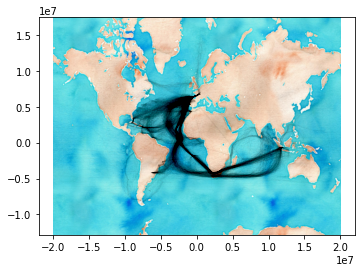

In [33]:
ax = cliwoc.to_crs(epsg=3857).plot(linewidth=0.01, alpha=0.5, color="k")
ctx.add_basemap(ax, 
                source="world_watercolor.tif"
               )

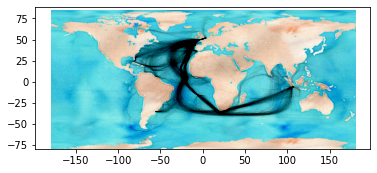

In [47]:
ax = cliwoc.plot(linewidth=0.01, alpha=0.5, color="k")
ctx.add_basemap(ax,
                crs=cliwoc.crs.to_string(),
                source="world_watercolor.tif",
                reset_extent=False
               )

ValueError: cannot convert float NaN to integer

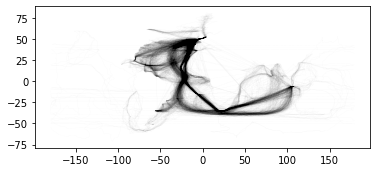

In [50]:
ax = cliwoc.cx[-50:0, :].plot(linewidth=0.01, alpha=0.5, color="k")
ctx.add_basemap(ax,
                crs=cliwoc.crs.to_string(),
                source="world_watercolor.tif",
                reset_extent=True
               )

In [51]:
print(ax.get_xlim())

print(ax.get_ylim())

(-197.96749999999997, 197.9775)
(-78.76849999999999, 88.3985)


In [44]:
print(ax.get_xlim())

print(ax.get_ylim())

(-197.97799999999995, 197.97799999999998)
(-79.21207497773345, 88.3985)
